## Predicting Number of Flu Cases for the Coming Weeks

In this notebook, we're going to go through an example machine learning project with the goal of predicting 
the number of flu cases for the coming weeks.

## 1. Problem definition

> How well can we predict the the number of flu cases for the coming weeks?

## 2. Data

The data is downloaded from the Kaggle: https://www.kaggle.com/code/saonideb/linear-regression-with-time-series-17-05-22/input?select=flu-trends.csv

The Flu Trends dataset contains records of doctor's visits for the flu for weeks between 2009 and 2016.

## 3. Methods
We will take two approaches. 

In the first we'll forecast doctor's visits using lag features. 

Our second approach will be to forecast doctor's visits using lags of another set of time series: flu-related search terms as captured by Google Trends.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

In [3]:
# define lag plots
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [4]:
# import data
flu_trends = pd.read_csv("flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

In [5]:
flu_trends.head()

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180
2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,8,...,16,6,9,24,28,25,25,25,9,132
2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,15,...,8,5,12,21,26,26,29,24,13,109
2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,15,...,8,8,12,33,29,21,27,30,9,120


In [7]:
flu_trends.columns.to_list()

['AInfluenza',
 'AcuteBronchitis',
 'BodyTemperature',
 'BraunThermoscan',
 'BreakAFever',
 'Bronchitis',
 'ChestCold',
 'ColdAndFlu',
 'ColdOrFlu',
 'ColdVersusFlu',
 'ColdVsFlu',
 'ContagiousFlu',
 'CoughFever',
 'CureFlu',
 'CureTheFlu',
 'DangerousFever',
 'DoIHaveTheFlu',
 'EarThermometer',
 'EarlyFluSymptoms',
 'Expectorant',
 'ExposedToFlu',
 'FeverCough',
 'FeverFlu',
 'FeverReducer',
 'FightTheFlu',
 'FluAndCold',
 'FluAndFever',
 'FluCare',
 'FluChildren',
 'FluComplications',
 'FluContagiousPeriod',
 'FluContagious',
 'FluCough',
 'FluDuration',
 'FluFever',
 'FluGerms',
 'FluHeadache',
 'FluHowLong',
 'FluInChildren',
 'FluIncubationPeriod',
 'FluIncubation',
 'FluLasts',
 'FluLength',
 'FluMedicine',
 'FluOrCold',
 'FluRecovery',
 'FluRelief',
 'FluRemedies',
 'FluRemedy',
 'FluReport',
 'FluReports',
 'FluSymptoms',
 'FluTest',
 'FluTreatment',
 'FluTreatments',
 'FluVersusCold',
 'FluVsCold',
 'GetOverTheFlu',
 'GetRidOfTheFlu',
 'HavingTheFlu',
 'HighFever',
 'HowLongCo

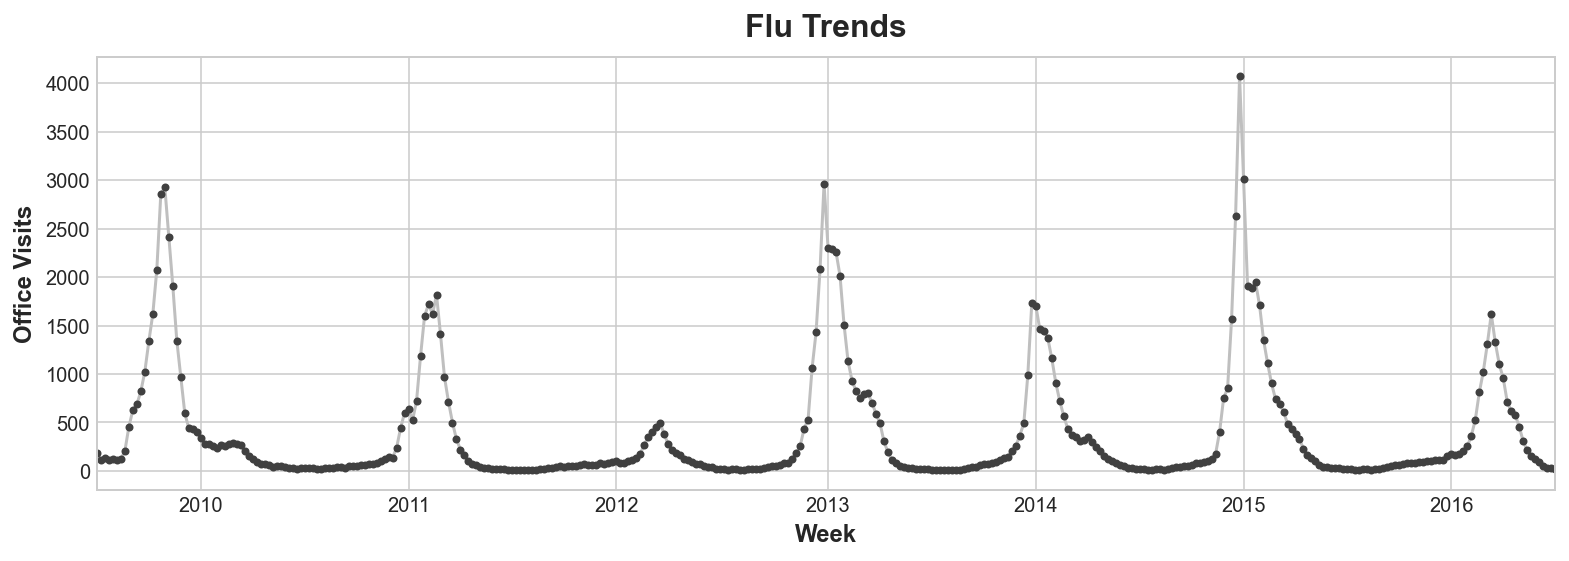

In [8]:
ax = flu_trends.FluVisits.plot(title='Flu Trends', **plot_params)
_ = ax.set(ylabel="Office Visits")

Our Flu Trends data shows **irregular cycles** instead of a regular seasonality: the peak tends to occur around the new year, but sometimes earlier or later, sometimes larger or smaller. 

Modeling these cycles with **lag features** will allow our forecaster to react dynamically to changing conditions instead of being constrained to exact dates and times as with seasonal features.

Let's take a look at the lag and autocorrelation plots first:

C:\Users\zxy23\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


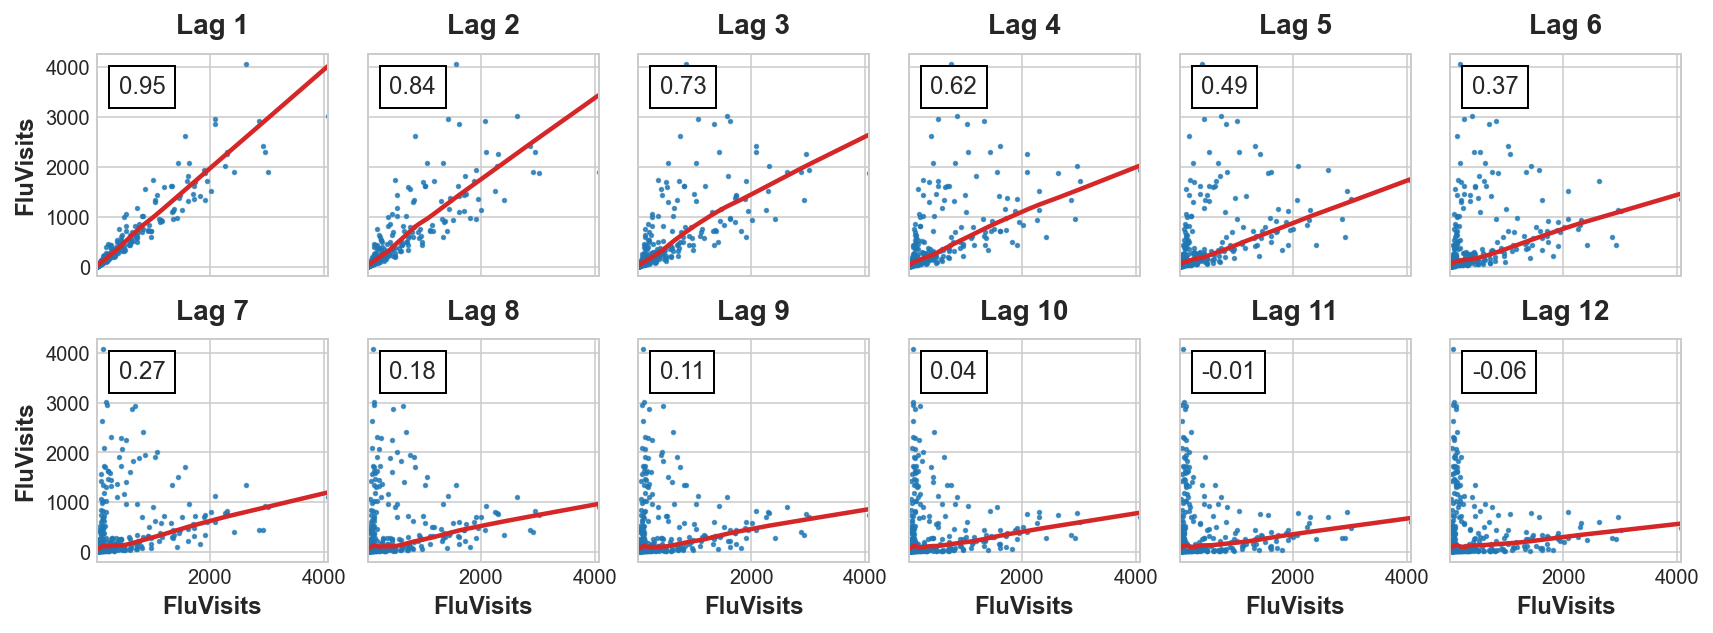

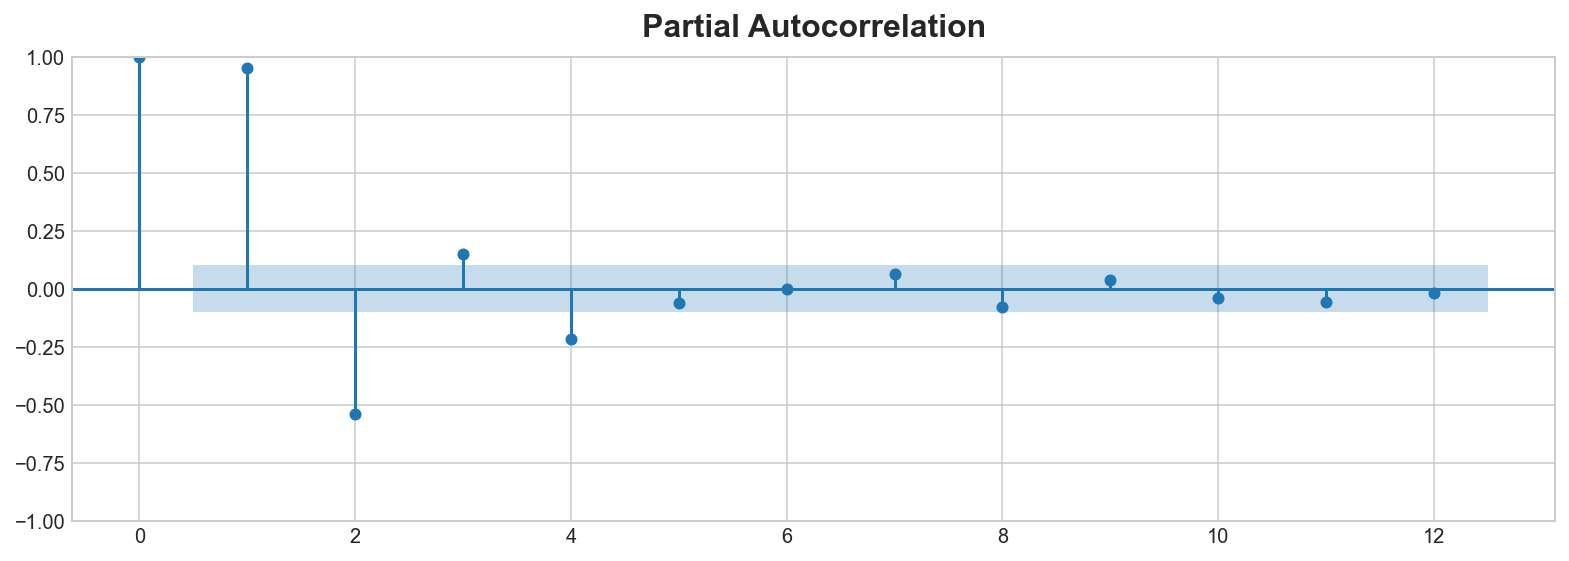

In [9]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)
_ = plot_pacf(flu_trends.FluVisits, lags=12)

The lag plots indicate that the relationship of `FluVisits` to its lags is **mostly linear**, while the partial autocorrelations suggest the dependence can be captured using lags 1, 2, 3, and 4. 

We can lag a time series in Pandas with the `shift` method. For this problem, we'll fill in the missing values the lagging creates with 0.0.

In [10]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(flu_trends.FluVisits, lags=4)
X = X.fillna(0.0)

Previously, we were able to create forecasts for as many steps as we liked beyond the training data. When using lag features, however, we are **limited** to forecasting time steps whose lagged values are available. Using a lag 1 feature on Monday, we can't make a forecast for Wednesday because the lag 1 value needed is Tuesday which hasn't happened yet.

We'll see strategies for handling this problem later. For this example, we'll just use values from a test set.

In [11]:
# Create target series and data splits
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

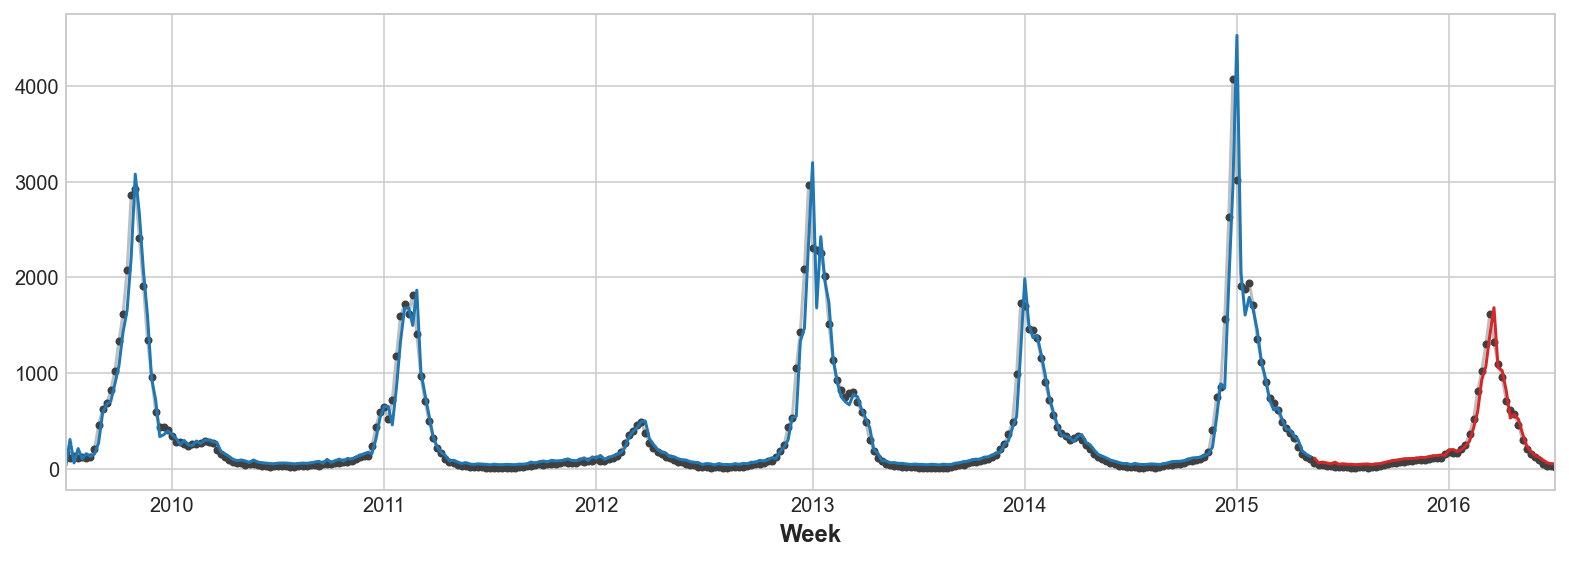

In [12]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

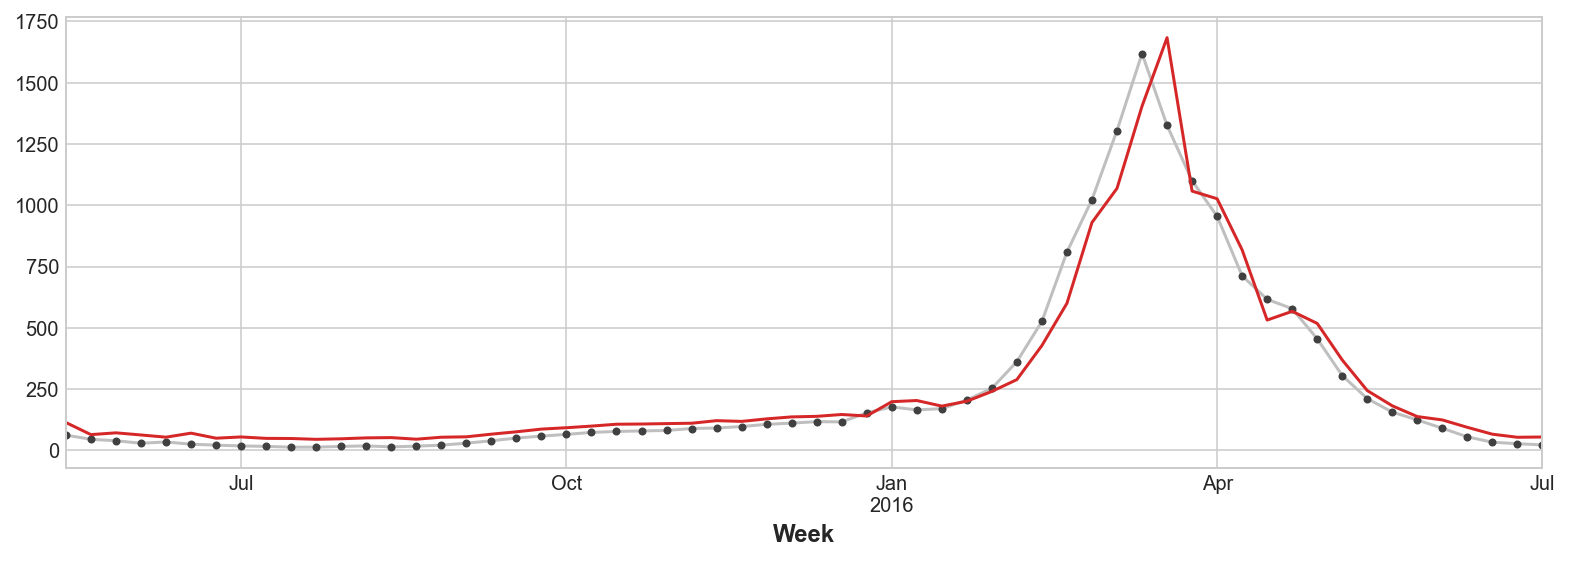

In [13]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

Looking just at the forecast values, we can see how our model **needs a time step** to react to sudden changes in the target series. This is a common **limitation** of models using only lags of the target series as features.

To improve the forecast we could try to find **leading indicators**, time series that could provide an "early warning" for changes in flu cases. For our second approach then we'll add to our training data the popularity of some flu-related search terms as measured by Google Trends.

Plotting the search phrase **'FluCough'** against the target **'FluVisits'** suggests such search terms could be useful as leading indicators: flu-related searches tend to become more popular in the weeks prior to office visits.

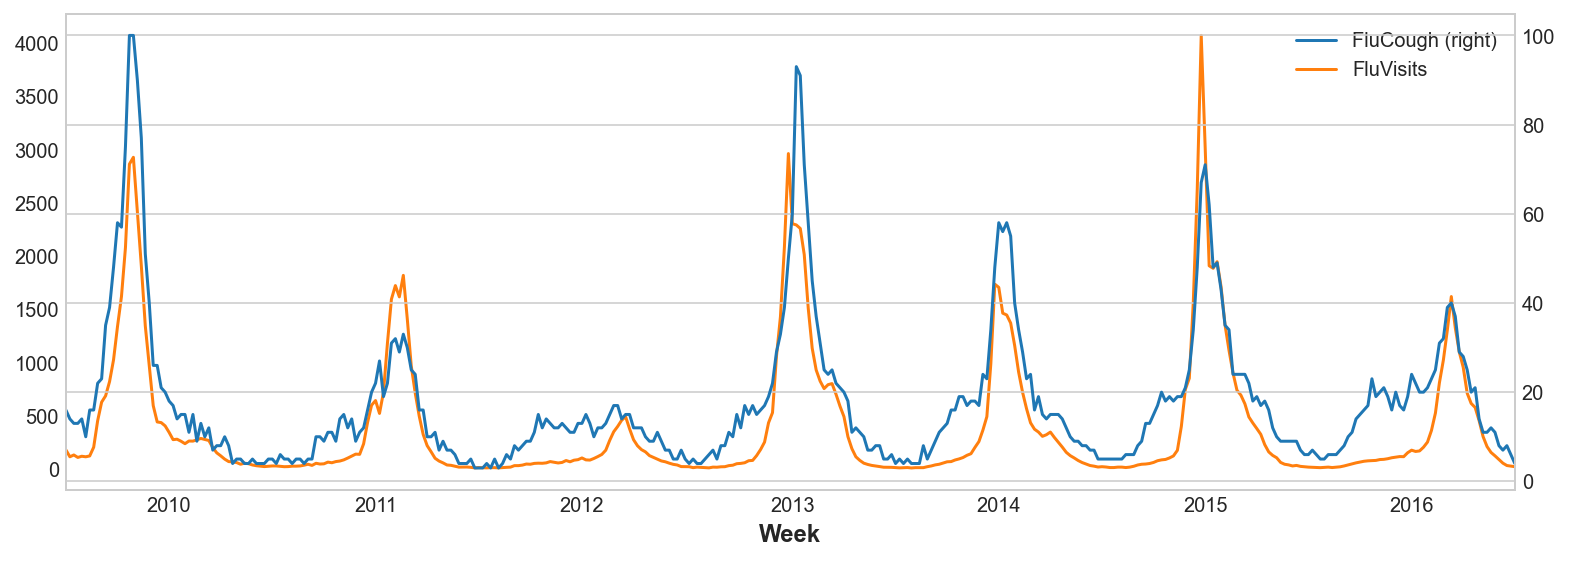

In [14]:
ax = flu_trends.plot(
    y=["FluCough", "FluVisits"],
    secondary_y="FluCough",
)

The dataset contains 129 such terms, but we'll just use a few.

In [15]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

# Create three lags for each search term
X0 = make_lags(flu_trends[search_terms], lags=3)
X0.columns = [' '.join(col).strip() for col in X0.columns.values]

# Create four lags for the target, as before
X1 = make_lags(flu_trends['FluVisits'], lags=4)

# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(0.0)

Our forecasts are a bit rougher, but our model appears to be better able to anticipate sudden increases in flu visits, suggesting that the several time series of search popularity were indeed effective as leading indicators.

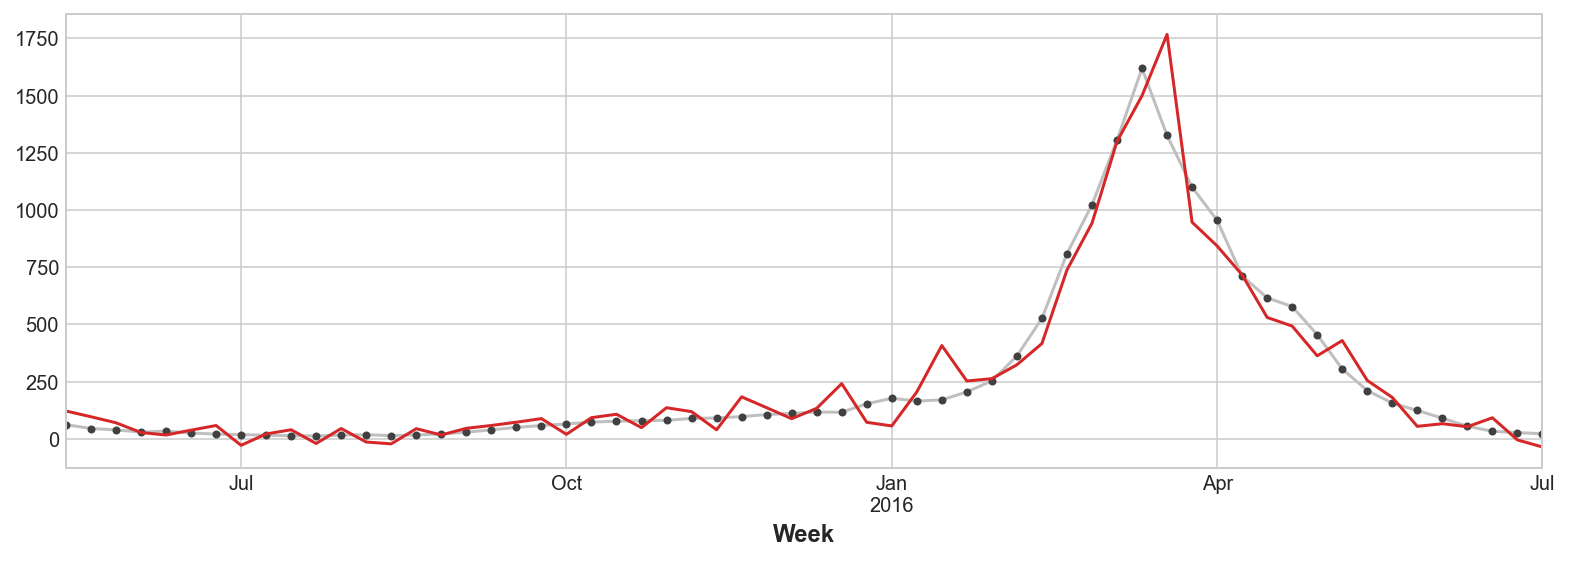

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

The time series illustrated in notebook are what you might call **"purely cyclic"**: they have no obvious trend or seasonality. It's not uncommon though for time series to possess trend, seasonality, and cycles -- all three components at once. 

You could model such series with linear regression by just **adding the appropriate features for each component**. You can even combine models trained to learn the components separately, which we'll learn how to do later with forecasting hybrids.

## 5. Forecasting with Machine Learning

In this example we'll apply the **MultiOutput** and **Direct** strategies to the Flu Trends data, this time making true forecasts for multiple weeks beyond the training period.

We'll define our forecasting task to have an 8-week horizon with a 1-week lead time. In other words, we'll be forecasting eight weeks of flu cases starting with the following week.

The next cell sets up the example and defines a helper function `plot_multistep`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax


In [2]:
flu_trends = pd.read_csv("flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

In [3]:
flu_trends.head()

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180
2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,8,...,16,6,9,24,28,25,25,25,9,132
2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,15,...,8,5,12,21,26,26,29,24,13,109
2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,15,...,8,8,12,33,29,21,27,30,9,120


First we'll prepare our target series (weekly office visits for the flu) for multistep forecasting. Once this is done, training and prediction will be very straightfoward.

In [4]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

In [5]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

In [6]:
# Four weeks of lag features
y = flu_trends.FluVisits.copy()
X = make_lags(y, lags=4).fillna(0.0)

# Eight-week forecast
y = make_multistep_target(y, steps=8).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

### Multioutput model

We'll use `linear regression` as a MultiOutput strategy. Once we have our data prepared for multiple outputs, training and prediction is the same as always.

In [7]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Remember that a multistep model will produce a complete forecast for each instance used as input. There are 269 weeks in the training set and 90 weeks in the test set, and we now have an 8-step forecast for each of these weeks.

Train RMSE: 389.12
Test RMSE: 582.33


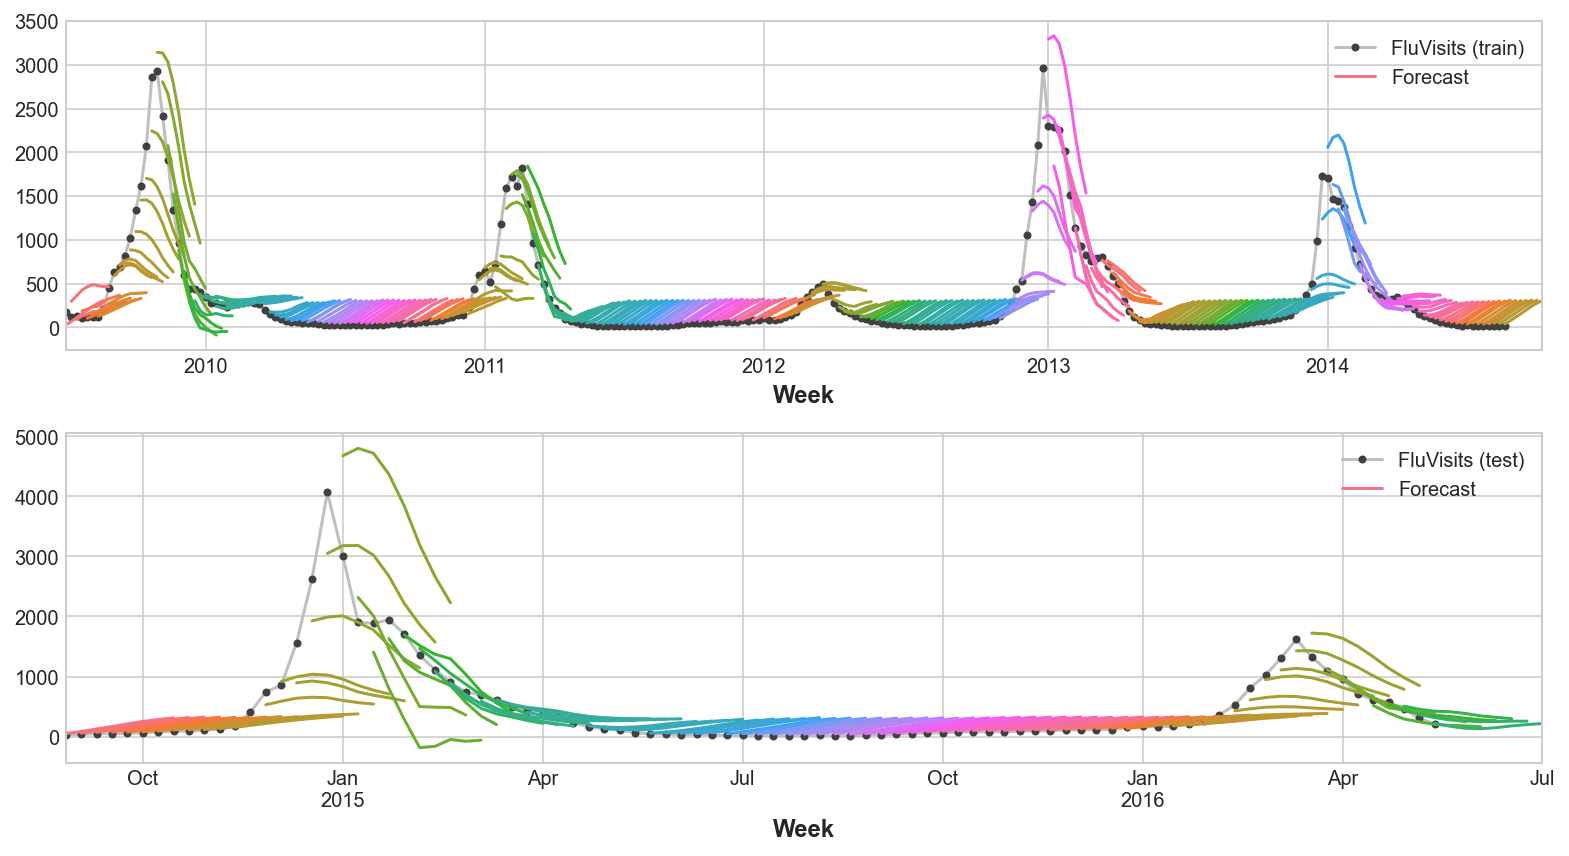

In [8]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

### Direct strategy

`XGBoost` can't produce multiple outputs for regression tasks. But by applying the Direct reduction strategy, we can still use it to produce multi-step forecasts. This is as easy as wrapping it with scikit-learn's `MultiOutputRegressor`.

In [10]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

`XGBoost` here is clearly overfitting on the training set. But on the test set it seems it was able to capture some of the dynamics of the flu season better than the `linear regression` model. It would likely do even better with some hyperparameter tuning.

Train RMSE: 1.22
Test RMSE: 526.45


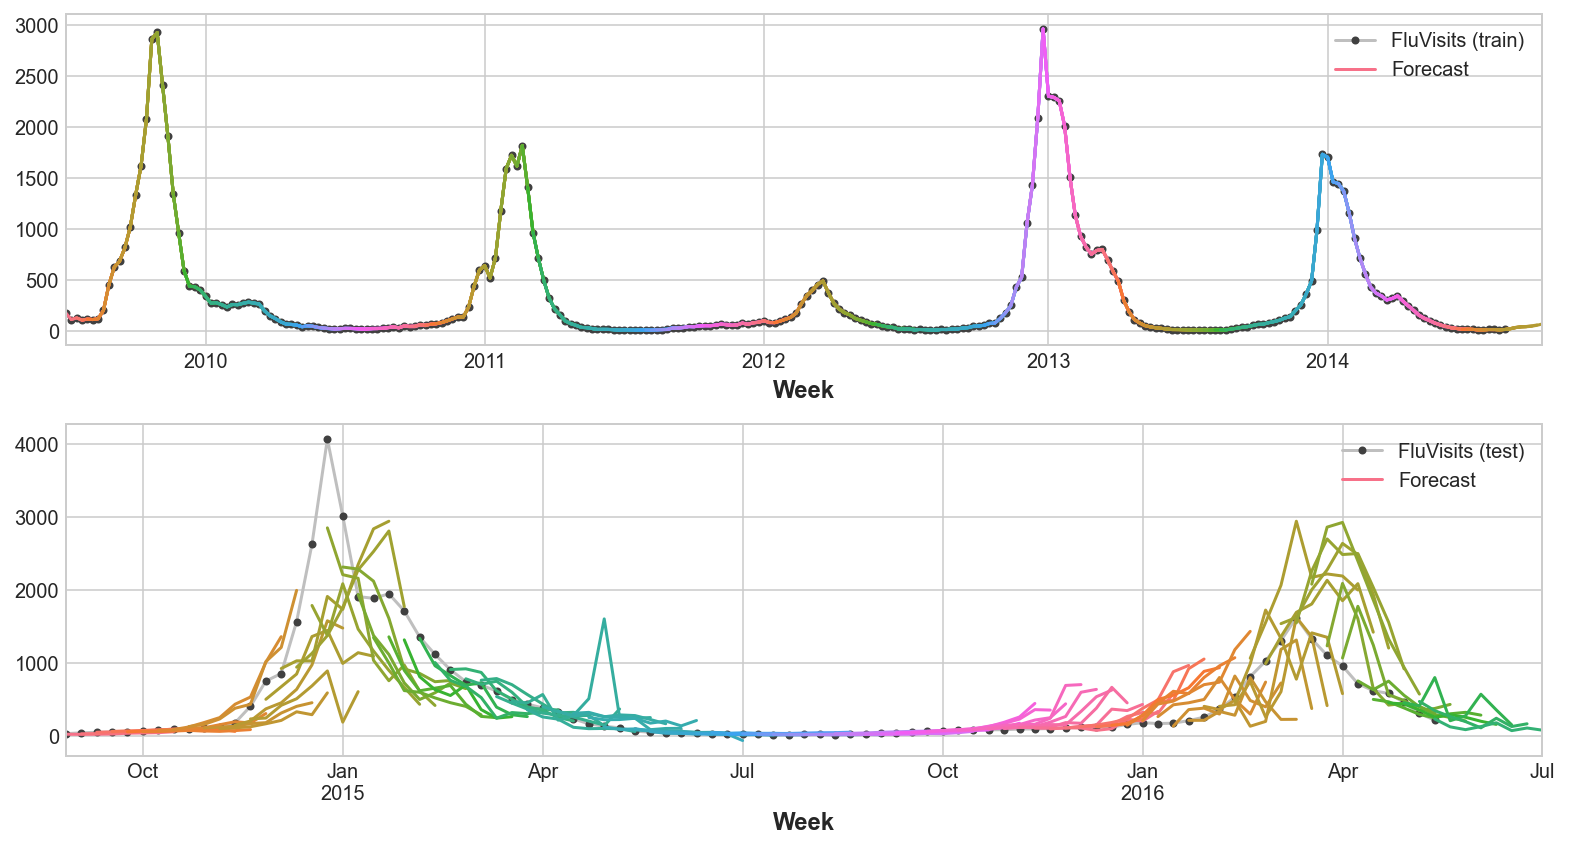

In [11]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

To use the **DirRec strategy**, you would only need to replace MultiOutputRegressor with another scikit-learn wrapper, RegressorChain. The Recursive strategy we would need to code ourselves.